<a href="https://colab.research.google.com/github/petergchang/ssm-jax/blob/main/ssm_jax/nlgssm/demos/pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pendulum Tracking Example for NLGSSM

This notebook demonstrates a simple pendulum tracking example for EKF, UKF, SLF, and PF using the implementations in `ssm_jax/nlgssm`.

The example is taken from Simo Särkkä (2013), “Bayesian Filtering and Smoothing,” Cambridge University Press. Available: https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf

The JAX translation is by Peter G. Chang ([@petergchang](https://github.com/petergchang)) and taken from the [särkkä-jax](https://github.com/petergchang/sarkka-jax) repo.



## 0. Imports and Formatting

In [1]:
# TODO: Change to https://github.com/probml/ssm-jax.git after PR merged
!git clone https://github.com/petergchang/ssm-jax.git
%cd ssm-jax
!pip install -e .

Cloning into 'ssm-jax'...
remote: Enumerating objects: 840, done.
remote: Counting objects: 100% (301/301), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 840 (delta 159), reused 229 (delta 141), pack-reused 539
Receiving objects: 100% (840/840), 2.75 MiB | 4.36 MiB/s, done.
Resolving deltas: 100% (487/487), done.
/content/ssm-jax
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/ssm-jax
     |████████████████████████████████| 140 kB 13.8 MB/s 
     |████████████████████████████████| 72 kB 614 kB/s 
     |████████████████████████████████| 272 kB 68.1 MB/s 
  Running setup.py develop for ssm-jax


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import chex
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import vmap
from jax import lax
from jax import jacfwd
from typing import Callable

from ssm_jax.lgssm.inference import lgssm_filter
from ssm_jax.lgssm.models import LinearGaussianSSM
from ssm_jax.nlgssm.extended_inference import extended_kalman_filter
from ssm_jax.nlgssm.containers import NLGSSMParams

In [3]:
# For pretty print of ndarrays
jnp.set_printoptions(formatter={'float_kind':"{:.2f}".format})

## 1. Simulation and Plotting

We simulate the pendulum data using the following transition model:
\begin{align*}
  \begin{pmatrix} x_{1,k} \\ x_{2,k} \end{pmatrix} &= 
  \begin{pmatrix} x_{1,k-1} + x_{2,k-1} \Delta t \\
    x_{2,k-1} - g \sin(x_{1,k-1}) \Delta t
  \end{pmatrix} + q_{k-1} \\
  y_{k} &= \sin(x_{1,k}) + r_k \\
  y_{x_k} &= \arcsin(y_k) = \arcsin(\sin(x_{1,k}) + r_k)
\end{align*}

In [4]:
# Some parameters
dt = 0.0125
g = 9.8
q_c = 1
r = 0.3

# Lightweight container for pendulum parameters
@chex.dataclass
class PendulumParams:
    initial_state: chex.Array = jnp.array([jnp.pi/2, 0])
    dynamics_function: Callable = lambda x: jnp.array([x[0] + x[1]*dt, 
                                                       x[1] - g*jnp.sin(x[0])*dt])
    dynamics_covariance: chex.Array = jnp.array([[q_c*dt**3/3, q_c*dt**2/2],
                                                 [q_c*dt**2/2,      q_c*dt]])
    emission_function: Callable = lambda x: jnp.array([jnp.sin(x[0])])
    emission_covariance: chex.Array = jnp.eye(1) * (r**2)

In [5]:
# Pendulum simulation (Särkkä Example 3.7)
def simulate_pendulum(params=PendulumParams(), key=0, num_steps=400):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    # Unpack parameters
    M, N = params.initial_state.shape[0], params.emission_covariance.shape[0]
    f, h = params.dynamics_function, params.emission_function
    Q, R = params.dynamics_covariance, params.emission_covariance

    def _step(carry, rng):
        state = carry
        rng1, rng2 = jr.split(rng, 2)

        next_state = f(state) + jr.multivariate_normal(rng1, jnp.zeros(M), Q)
        obs = h(next_state) + jr.multivariate_normal(rng2, jnp.zeros(N), R)
        return next_state, (next_state, obs)

    rngs = jr.split(key, num_steps)
    _, (states, observations) = lax.scan(
        _step, params.initial_state, rngs
    )
    return states, observations

states, obs = simulate_pendulum()

In [6]:
# Helper function for plotting
def plot_pendulum(time_grid, x_tr, x_obs, x_est=None, est_type=""):
    plt.figure()
    plt.plot(time_grid, x_tr, color='darkgray', linewidth=4, label="True Angle")
    plt.plot(time_grid, x_obs, 'ok', fillstyle='none', ms=1.5, label='Measurements')
    if x_est is not None:
        plt.plot(time_grid, x_est, color='k', linewidth=1.5, label=f"{est_type} Estimate")
    plt.xlabel('Time $t$'); plt.ylabel('Pendulum angle $x_{1,k}$')
    plt.xlim(0, 5); plt.ylim(-3, 5)
    plt.xticks(jnp.arange(0.5, 4.6, 0.5))
    plt.yticks(jnp.arange(-3, 5.1, 1))
    plt.gca().set_aspect(0.5)
    plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor='k');
    plt.show()

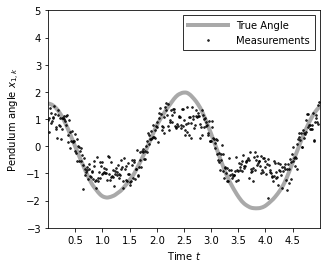

In [7]:
# Create time grid for plotting
time_grid = jnp.arange(0.0, 5.0, step=dt)

# Plot the generated data
plot_pendulum(time_grid, states[:,0], obs)

In [8]:
# Compute RMSE
def compute_rmse(y, y_est):
    return jnp.sqrt(jnp.sum((y-y_est)**2) / len(y))

# Compute RMSE of estimate and print comparison with 
# standard deviation of measurement noise
def compute_and_print_rmse_comparison(y, y_est, R, est_type=""):
    rmse_est = compute_rmse(y, y_est)
    print(f'{f"The RMSE of the {est_type} estimate is":<40}: {rmse_est:.2f}')
    print(f'{"The std of measurement noise is":<40}: {jnp.sqrt(R):.2f}')

## 2. Extended Kalman Filter

In [9]:
pendulum_params = PendulumParams()

# Define parameters for EKF
ekf_params = NLGSSMParams(
    initial_mean = pendulum_params.initial_state,
    initial_covariance = jnp.eye(states.shape[-1])*0.1,
    dynamics_function = pendulum_params.dynamics_function,
    dynamics_covariance = pendulum_params.dynamics_covariance,
    emission_function = pendulum_params.emission_function,
    emission_covariance = pendulum_params.emission_covariance
)

# Compute EKF estimate using SSM Library
ekf_posterior = extended_kalman_filter(ekf_params, obs)
m_ekf = ekf_posterior.filtered_means[:,0]

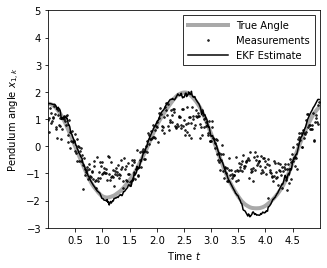

In [10]:
# Plot EKF results
plot_pendulum(time_grid, states[:,0], obs, x_est=m_ekf, est_type="EKF")

In [11]:
compute_and_print_rmse_comparison(states[:,0], m_ekf, r, "EKF")

The RMSE of the EKF estimate is         : 0.14
The std of measurement noise is         : 0.55
